# Prescription

In [484]:
using CSV, DataFrames, Random, Gurobi, JuMP, Statistics, ScikitLearn, Plots

In [485]:
# Load the data
df_preds = CSV.read("predictions.csv", DataFrame)
df_energy = CSV.read("energy_sources.csv", DataFrame)
df_train = CSV.read("demand_train.csv", DataFrame)
df_test = CSV.read("demand_test.csv", DataFrame);

In [486]:
# Create X and y
X_train = select(df_train, Not([:Column1, :date, :demand]))
y_train = df_train[!,:demand]
X_test = select(df_test, Not([:Column1, :date, :demand]))
y_test = df_test[!,:demand]
first(X_test, 5)

5×16 DataFrame
 Row │ RRP      demand_pos_RRP  RRP_positive  demand_neg_RRP  RRP_negative  fr ⋯
     │ Float64  Float64         Float64       Float64         Float64       Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 47.3506       1.07629e5       47.3506            0.0         0.0        ⋯
   2 │ 59.0447       1.08418e5       59.0447            0.0         0.0
   3 │ 70.2026       1.12736e5       70.2026            0.0         0.0
   4 │ 79.6057       1.148e5         79.6057            0.0         0.0
   5 │ 51.0587   93762.8             55.6113         5196.73      -31.0821     ⋯
                                                              11 columns omitted

In [487]:
df_energy

5×5 DataFrame
 Row │ Energy Source  Capacity  Emissions  Cost   2021 Usage
     │ String15       Int64     Int64      Int64  Int64
─────┼───────────────────────────────────────────────────────
   1 │ Brown coal         4708       5740     68    34060028
   2 │ Natural gas        2230       3430     39     1956916
   3 │ Hydro               808       1610    136     7080623
   4 │ Wind                993         77    102     2851962
   5 │ Solar               528        287    114     4631909

In [488]:
# Define iterators
T = size(X_test, 1);
I = size(df_energy, 1);

In [489]:
C = df_energy[!,:Capacity] * 24 # 1 = Brown coal, 2 = Natural gas, 3 = Hydro, 4 = Wind, 5 = Solar
e = df_energy[!,:Emissions] # Kg CO2 per MWh
E = 85190000000 * 316 / 365 # Target emissions in kg CO2 in T days
# E = 118000000000
c = df_energy[!,:Cost] # LCOE in AUD/MWh
p = 304; # AUD / MWh
total_demand = sum(y_test);

In [490]:
results = DataFrame(Model=String[], Obj=Float64[], Profit=Float64[], Emissions=Float64[], Unmet_Demand=Float64[], 
    Coal=Float64[], Gas=Float64[], Hydro=Float64[], Wind=Float64[], Solar=Float64[])

0×10 DataFrame
 Row │ Model   Obj      Profit   Emissions  Unmet_Demand  Coal     Gas      Hy ⋯
     │ String  Float64  Float64  Float64    Float64       Float64  Float64  Fl ⋯
─────┴──────────────────────────────────────────────────────────────────────────
                                                               3 columns omitted

## Perfect Foresight Model - No Demand

In [491]:
M = 1000000

model = Model(Gurobi.Optimizer);

# Decision variable
@variable(model, z[i=1:I,t=1:T] >= 0)

# Auxiliary variables
@variable(model, a[t=1:T] >= 0)
@variable(model, x[t=1:T], Bin)

# Constraints
@constraint(model, emissions_constraint, sum(sum(e[i] * z[i,t] for i=1:I) for t=1:T) <= E)
@constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  C[i])

# Linearize the min function
@constraint(model, linearize_constraint_1[t=1:T], a[t] <= sum(z[i,t] for i=1:I))
@constraint(model, linearize_constraint_2[t=1:T], a[t] <= y_test[t])
@constraint(model, linearize_constraint_3[t=1:T], a[t] >= sum(z[i,t] for i=1:I) - M * (1 - x[t]))
@constraint(model, linearize_constraint_4[t=1:T], a[t] >= y_test[t] - M * x[t])

@objective(model, Min, sum(sum(c[i] * z[i,t] for i=1:I) for t=1:T) - p * sum(a[t] for t=1:T))

# set_optimizer_attribute(model, "TimeLimit", 60.0);
optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2845 rows, 2212 columns and 8216 nonzeros
Model fingerprint: 0xb93d023a
Variable types: 1896 continuous, 316 integer (316 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e+01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 0.0000000
Presolve removed 1896 rows and 0 columns
Presolve time: 0.01s
Presolved: 949 rows, 2212 columns, 6320 nonzeros
Variable types: 1896 continuous, 316 integer (316 binary)

Root relaxation: objective -7.884782e+09, 615 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Curre

In [492]:
optimal_prescriptions = JuMP.value.(z)
obj_value = JuMP.objective_value(model)

total_cost = sum(sum(optimal_prescriptions[i,t] * c[i] for i=1:I) for t=1:T)
total_emissions = sum(sum(optimal_prescriptions[i,t] * e[i] for i=1:I) for t=1:T)
total_sell = [min(y_test[t], sum(optimal_prescriptions[i,t] for i=1:I)) for t=1:T]
total_revenue = p * sum(total_sell)
total_profit = total_revenue - total_cost

production = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
unmet_demand = sum(y_test[t] - production[t] for t=1:T)

optimal_coal = optimal_prescriptions[1, :]
optimal_gas = optimal_prescriptions[2, :]
optimal_hydro = optimal_prescriptions[3, :]
optimal_wind = optimal_prescriptions[4, :]
optimal_solar = optimal_prescriptions[5, :]

total_coal = sum(optimal_coal)
total_gas = sum(optimal_gas)
total_hydro = sum(optimal_hydro)
total_wind = sum(optimal_wind)
total_solar = sum(optimal_solar);

In [493]:
avg_unmet = sum(unmet_demand) / T

6440.666019673538

In [494]:
push!(results, (Model="PF - No Demand", Obj=obj_value, Profit=total_profit, Emissions=total_emissions, Unmet_Demand=unmet_demand, 
    Coal=total_coal, Gas=total_gas, Hydro=total_hydro, Wind=total_wind, Solar=total_solar))

1×10 DataFrame
 Row │ Model           Obj         Profit     Emissions   Unmet_Demand  Coal   ⋯
     │ String          Float64     Float64    Float64     Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PF - No Demand  -7.88478e9  7.88478e9  7.37535e10     2.03525e6  9.4194 ⋯
                                                               5 columns omitted

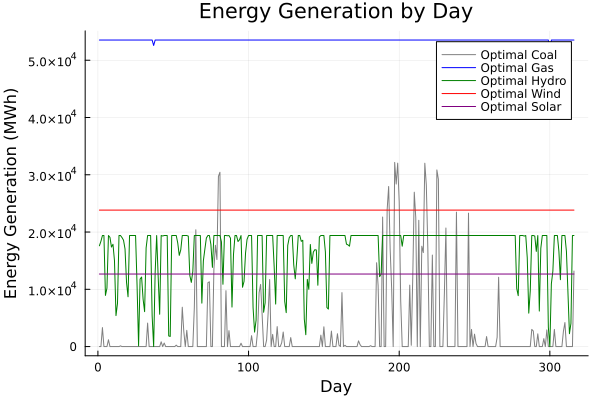

In [495]:
days = 1:T 

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
plot!(days, optimal_gas, label = "Optimal Gas", color = :blue)
plot!(days, optimal_hydro, label = "Optimal Hydro", color = :green)
plot!(days, optimal_wind, label = "Optimal Wind", color = :red)
plot!(days, optimal_solar, label = "Optimal Solar", color = :purple)

title!("Energy Generation by Day")
xlabel!("Day")
ylabel!("Energy Generation (MWh)")


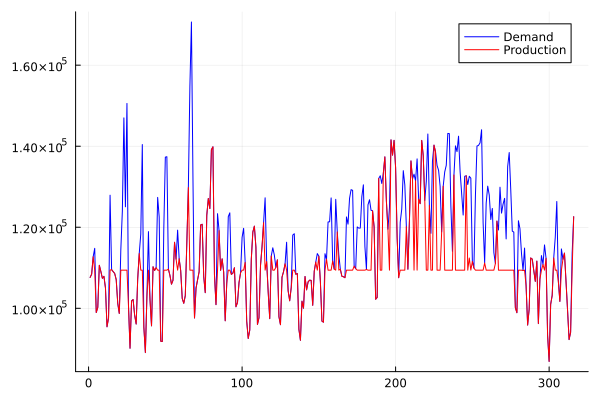

In [496]:
total_production_days = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
plot(days, y_test, label = "Demand", color = :blue)
plot!(days, total_production_days, label = "Production", color = :red)

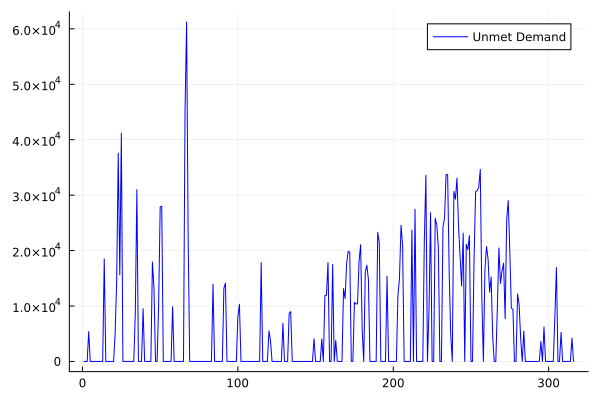

In [497]:
unmet_demand = y_test - total_production_days
plot(days, unmet_demand, label = "Unmet Demand", color = :blue)

## Perfect Foresight Model - With Demand

In [498]:
function pf_demand(alpha=1000)
    model = Model(Gurobi.Optimizer);

    @variable(model, z[i=1:I,t=1:T] >= 0)

    @constraint(model, emissions_constraint, sum(sum(z[i,t] * e[i] for i=1:I) for t=1:T) <= E)
    @constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  C[i])

    # Auxiliary variable for modeling max operator in objective function
    @variable(model, u[t=1:T] >= 0) 
    @constraint(model, [t=1:T], u[t] >= y_test[t] - sum(z[i,t] for i=1:I))
    @constraint(model, [t=1:T], u[t] >= 0)

    @objective(model, Min, sum(sum(z[i,t] * (c[i] - p) for i=1:I) + alpha * u[t] for t=1:T));

    #set_optimizer_attribute(model, "TimeLimit", 60.0);
    optimize!(model);
    
    optimal_prescriptions = JuMP.value.(z)
    obj_value = JuMP.objective_value(model)

    total_cost = sum(sum(optimal_prescriptions[i,t] * c[i] for i=1:I) for t=1:T)
    total_emissions = sum(sum(optimal_prescriptions[i,t] * e[i] for i=1:I) for t=1:T)
    total_sell = [min(y_test[t], sum(optimal_prescriptions[i,t] for i=1:I)) for t=1:T]
    total_revenue = p * sum(total_sell)
    total_profit = total_revenue - total_cost

    production = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
    unmet_demand = sum(y_test[t] - production[t] for t=1:T)

    return optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand
end

pf_demand (generic function with 2 methods)

In [499]:
optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand = pf_demand(250)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0x58775e3d
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e+02, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.00s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9348330e+11   2.486207e+08   0.000000e+00      0s
     489   -7.4200679e+09   0.000000e+00   0.000000e+00      0s

Solved in 489 iterations and 0.01 seconds (0.01 work units)
Optimal objective -7.4

([0.0 0.0 … 0.0 0.0; 51733.15999999996 52521.69500000001 … 53520.0 53520.0; … ; 23832.0 23832.0 … 23832.0 23832.0; 12672.0 12672.0 … 12672.0 12672.0], -7.420067942063351e9, 7.375353424657535e10, 7.867658105148049e9, 1.7903606523387865e6)

In [500]:
avg_unmet = sum(unmet_demand) / T

5665.698266894894

In [501]:
optimal_coal = optimal_prescriptions[1, :]
optimal_gas = optimal_prescriptions[2, :]
optimal_hydro = optimal_prescriptions[3, :]
optimal_wind = optimal_prescriptions[4, :]
optimal_solar = optimal_prescriptions[5, :]

total_coal = sum(optimal_coal)
total_gas = sum(optimal_gas)
total_hydro = sum(optimal_hydro)
total_wind = sum(optimal_wind)
total_solar = sum(optimal_solar);

In [503]:
push!(results, (Model="PF - Demand", Obj=obj_value, Profit=total_profit, Emissions=total_emissions, Unmet_Demand=unmet_demand, 
    Coal=total_coal, Gas=total_gas, Hydro=total_hydro, Wind=total_wind, Solar=total_solar));

In [546]:
results

18×10 DataFrame
 Row │ Model           Obj         Profit     Emissions   Unmet_Demand  Coal   ⋯
     │ String          Float64     Float64    Float64     Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PF - No Demand  -7.88478e9  7.88478e9  7.37535e10     2.03525e6  9.4194 ⋯
   2 │ PF - Demand     -7.42007e9  7.86766e9  7.37535e10     1.79036e6  1.1868
   3 │ SAA             -4.57892e6  7.61172e9  7.37535e10     1.65393e6  7.9149
   4 │ KNN = 1         -6.11114e9  7.85331e9  7.37535e10     1.80335e6  1.2061
   5 │ KNN = 2         -6.1015e9   7.85453e9  7.37535e10     1.79609e6  1.1953 ⋯
   6 │ KNN = 3         -6.10137e9  7.854e9    7.37535e10     1.79896e6  1.1996
   7 │ KNN = 4         -6.11209e9  7.85293e9  7.37535e10     1.79684e6  1.1964
   8 │ KNN = 5         -6.11722e9  7.85174e9  7.37535e10     1.79508e6  1.1938
   9 │ KNN = 6         -6.12451e9  7.85017e9  7.37535e10     1.7944e6   1.1928 ⋯
  10 │ KNN = 7         -6.12897e9  7.84941e9  7.37535e10     1.79507e6  1.1938
  11 │ KNN = 8         -6.12992e9  7.84984e9  7.37535e10     1.79779e6  1.1978
  12 │ KNN = 9         -6.13413e9  7.84918e9  7.37535e10     1.79682e6  1.1964
  13 │ KNN = 10        -6.13769e9  7.84998e9  7.37535e10     1.79753e6  1.1974 ⋯
  14 │ KNN = 11        -6.14256e9  7.85053e9  7.37535e10     1.7986e6   1.1990
  15 │ KNN = 12        -6.14913e9  7.8502e9   7.37535e10     1.8009e6   1.2024
  16 │ KNN = 13        -6.14986e9  7.84901e9  7.37535e10     1.79927e6  1.2000
  17 │ KNN = 14        -6.15448e9  7.8486e9   7.37535e10     1.79946e6  1.2003 ⋯
  18 │ KNN = 15        -6.15767e9  7.84762e9  7.37535e10     1.79868e6  1.1991
                                                               5 columns omitted

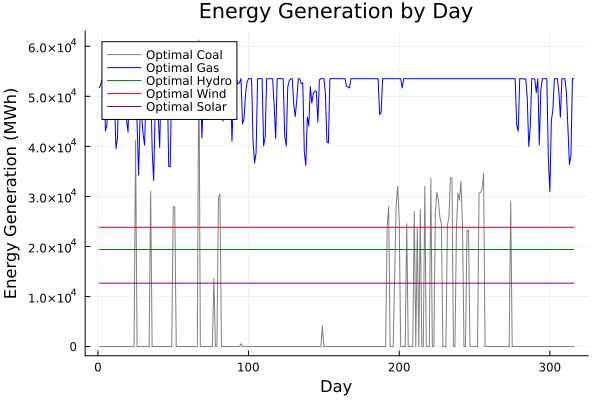

In [504]:
days = 1:T 

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
plot!(days, optimal_gas, label = "Optimal Gas", color = :blue)
plot!(days, optimal_hydro, label = "Optimal Hydro", color = :green)
plot!(days, optimal_wind, label = "Optimal Wind", color = :red)
plot!(days, optimal_solar, label = "Optimal Solar", color = :purple)

title!("Energy Generation by Day")
xlabel!("Day")
ylabel!("Energy Generation (MWh)")


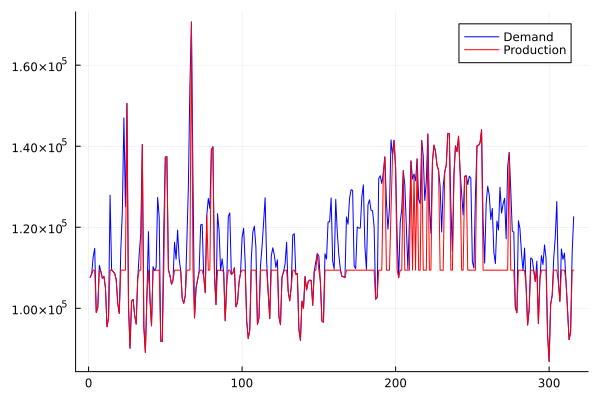

In [505]:
total_production_days = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
plot(days, y_test, label = "Demand", color = :blue)
plot!(days, total_production_days, label = "Production", color = :red)

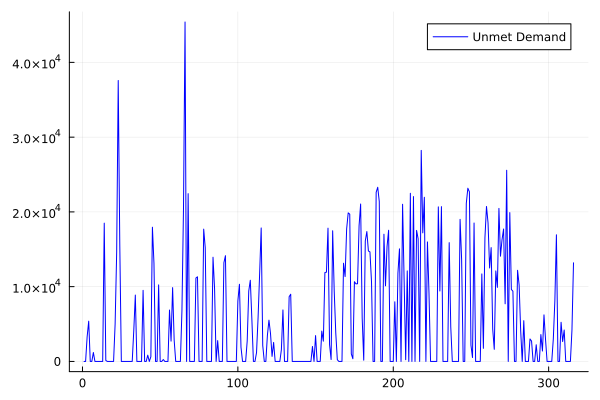

In [506]:
unmet_demand = y_test - total_production_days
plot(days, unmet_demand, label = "Unmet Demand", color = :blue)

In [507]:
obj_value_res = []
total_emissions_res = []
total_profit_res = []
total_production_res = []

alpha_nums = 0:1000

for alpha in alpha_nums
    optimal_prescriptions, obj_value, total_emissions, total_profit, total_production = pf_demand(alpha)
    push!(obj_value_res, obj_value)
    push!(total_emissions_res, total_emissions)
    push!(total_profit_res, total_profit)
    push!(total_production_res, total_production)
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0x061458bd
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e+02, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2213 rows and 1896 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9639157e+09   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -7.963915707e+09

User-callback calls 47, time in user-callback 0.00 sec
Set p

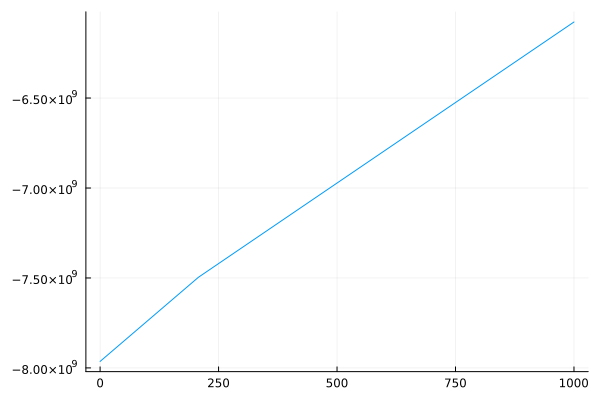

In [508]:
plot(alpha_nums, obj_value_res,legend=false)

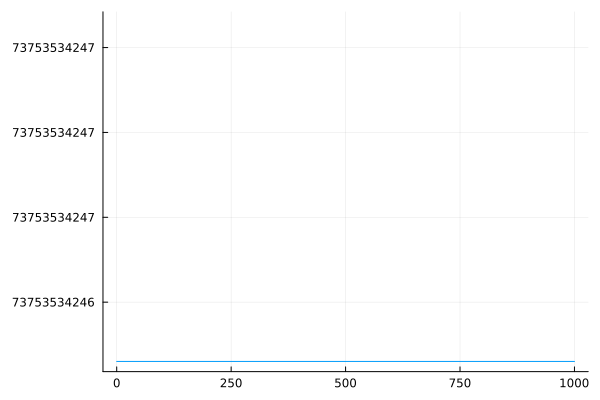

In [509]:
plot(alpha_nums, total_emissions_res,legend=false)

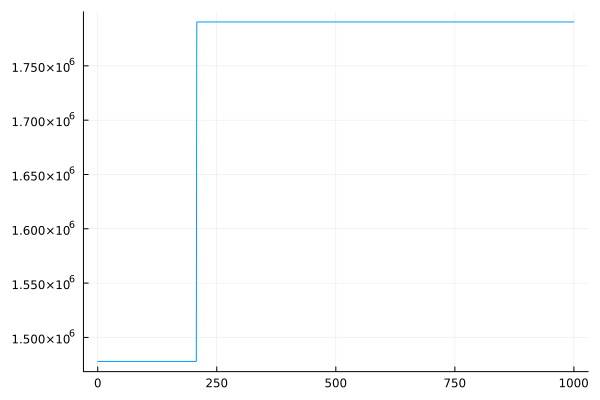

In [510]:
plot(alpha_nums, total_production_res,legend=false)

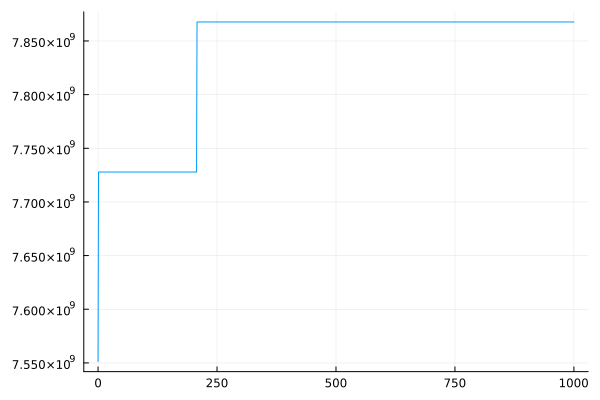

In [511]:
plot(alpha_nums, total_profit_res,legend=false)

## SAA

In [512]:
alpha = 250

model = Model(Gurobi.Optimizer);

@variable(model, z[i=1:I,t=1:T] >= 0)

@constraint(model, emissions_constraint, sum(sum(z[i,t] * e[i] for i=1:I) for t=1:T) <= E)
@constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  C[i])

# Auxiliary variable for modeling max operator in objective function
@variable(model, u[t=1:T] >= 0) 
for t in 1:T
    @constraint(model, u[t] >= y_train[t] - sum(z[i, t] for i=1:I))
    @constraint(model, u[t] >= 0)
end

@objective(model, Min, 1 / length(y_train) * sum(sum(z[i, t] * c[i] for i=1:I) - p * y_train[t] + alpha * u[t] for t=1:T));

optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0xdfee544a
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e-02, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.00s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7314145e+06   9.886765e+06   0.000000e+00      0s
     583   -4.5789169e+06   0.000000e+00   0.000000e+00      0s

Solved in 583 iterations and 0.00 seconds (0.01 work units)
Optimal objective -4.5

In [513]:
optimal_prescriptions = JuMP.value.(z)
obj_value = JuMP.objective_value(model)

total_cost = sum(sum(optimal_prescriptions[i,t] * c[i] for i=1:I) for t=1:T)
total_emissions = sum(sum(optimal_prescriptions[i,t] * e[i] for i=1:I) for t=1:T)
total_sell = [min(y_test[t], sum(optimal_prescriptions[i,t] for i=1:I)) for t=1:T]
total_revenue = p * sum(total_sell)
total_profit = total_revenue - total_cost

production = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
unmet_demand = sum(y_test[t] - production[t] for t=1:T);

In [514]:
optimal_coal = optimal_prescriptions[1, :]
optimal_gas = optimal_prescriptions[2, :]
optimal_hydro = optimal_prescriptions[3, :]
optimal_wind = optimal_prescriptions[4, :]
optimal_solar = optimal_prescriptions[5, :]

total_coal = sum(optimal_coal)
total_gas = sum(optimal_gas)
total_hydro = sum(optimal_hydro)
total_wind = sum(optimal_wind)
total_solar = sum(optimal_solar);

In [515]:
push!(results, (Model="SAA", Obj=obj_value, Profit=total_profit, Emissions=total_emissions, Unmet_Demand=unmet_demand, 
    Coal=total_coal, Gas=total_gas, Hydro=total_hydro, Wind=total_wind, Solar=total_solar))

3×10 DataFrame
 Row │ Model           Obj         Profit     Emissions   Unmet_Demand  Coal   ⋯
     │ String          Float64     Float64    Float64     Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PF - No Demand  -7.88478e9  7.88478e9  7.37535e10     2.03525e6  9.4194 ⋯
   2 │ PF - Demand     -7.42007e9  7.86766e9  7.37535e10     1.79036e6  1.1868
   3 │ SAA             -4.57892e6  7.61172e9  7.37535e10     1.65393e6  7.9149
                                                               5 columns omitted

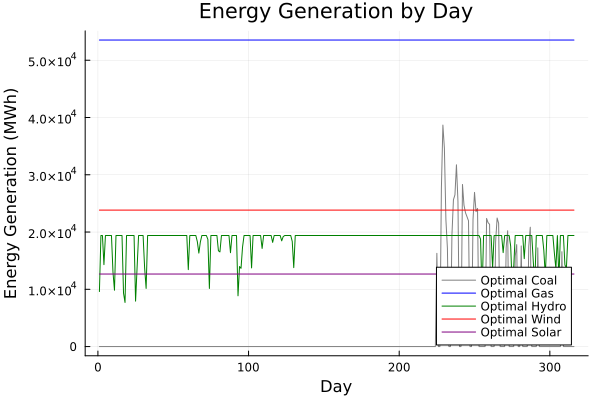

In [480]:
days = 1:T 

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
plot!(days, optimal_gas, label = "Optimal Gas", color = :blue)
plot!(days, optimal_hydro, label = "Optimal Hydro", color = :green)
plot!(days, optimal_wind, label = "Optimal Wind", color = :red)
plot!(days, optimal_solar, label = "Optimal Solar", color = :purple)

title!("Energy Generation by Day")
xlabel!("Day")
ylabel!("Energy Generation (MWh)")


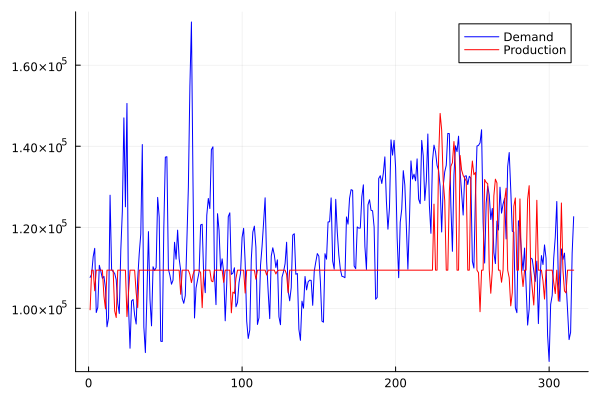

In [481]:
total_production_days = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
plot(days, y_test, label = "Demand", color = :blue)
plot!(days, total_production_days, label = "Production", color = :red)

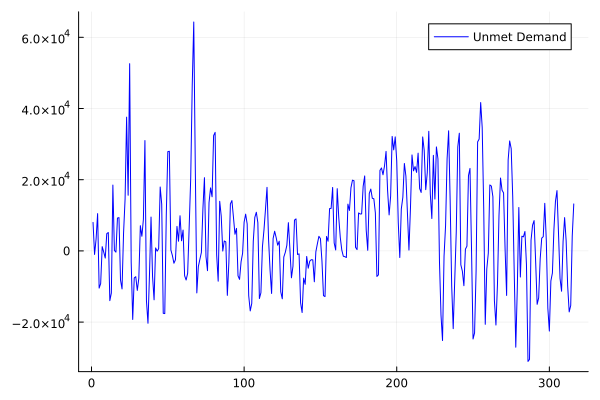

In [482]:
unmet_demand = y_test - total_production_days
plot(days, unmet_demand, label = "Unmet Demand", color = :blue)

In [520]:
prescriptions = JuMP.value.(z)

5×316 Matrix{Float64}:
     0.0       0.0      0.0      0.0  …      0.0      0.0      0.0      0.0
 53520.0   53520.0  53520.0  53520.0     53520.0  53520.0  53520.0  53520.0
  9611.03  19392.0  19392.0  14306.7     19392.0  19392.0  19392.0  19392.0
 23832.0   23832.0  23832.0  23832.0     23832.0  23832.0  23832.0  23832.0
 12672.0   12672.0  12672.0  12672.0     12672.0  12672.0  12672.0  12672.0

In [521]:
function prescription_vs_reality(z, y_test)
    """ Function to evaluate the quality of our prescriptions. 
    Assume we produce Z quantity of energy, would we able to meet all predicted demand (i.e. were the constraints restrictive/tight ?)
    Assume we produce Z quantity of energy, would we able to meet all true demand (i.e. in real life how far are we from satisfying demand ?)
    """
    res = []
    for t in 1:T 
        production_t = 0 # Total energy production at day t
        for i in 1:I
            production_t += z[i,t]
        end
        diff_pred = average_y - production_t # How much demand you were not able to meet (if demand = y_pred)
        diff_true = y_test[t] - production_t # How much demand you were not able to meet (if demand = y_true)
        push!(res, (produced=production_t, y_pred=average_y, not_met_pred=diff_pred, y_true=y_test[t],not_met_true=diff_true))
    end
    return res
end;

function carbon_emissions(z)
    """ Function to compute the total carbon emissions of our prescriptions, and daily carbon emissions."""
    total_emissions = []
    for t in 1:T 
        emissions_t = 0 # Total energy production at day t
        for i in 1:I
            emissions_t += z[i,t] * e[i]
        end
        push!(total_emissions, emissions_t)
    end 
    return sum(total_emissions), total_emissions
end;

#### Compare with Optimal Prescription

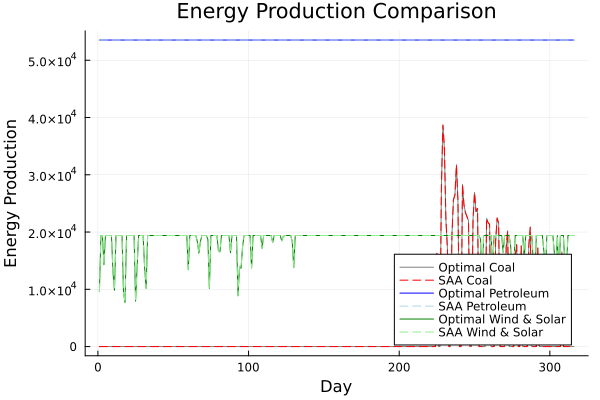

In [522]:
days = 1:T 

# Optimal prescriptions
optimal_coal = optimal_prescriptions[1, :];
optimal_petroleum = optimal_prescriptions[2, :];
optimal_wind_solar = optimal_prescriptions[3, :];

# SAA prescriptions
coal = prescriptions[1, :];
petroleum = prescriptions[2, :];
wind_solar = prescriptions[3, :];

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
plot!(days, coal, label = "SAA Coal", color = :red, linestyle = :dash)

plot!(days, optimal_petroleum, label = "Optimal Petroleum", color = :blue)
plot!(days, petroleum, label = "SAA Petroleum", color = :lightblue, linestyle = :dash)

plot!(days, optimal_wind_solar, label = "Optimal Wind & Solar", color = :green)
plot!(days, wind_solar, label = "SAA Wind & Solar", color = :lightgreen, linestyle = :dash)

title!("Energy Production Comparison")
xlabel!("Day")
ylabel!("Energy Production")


In [523]:
SAA_evaluate_results = prescription_vs_reality(prescriptions, y_test);
SAA_total_prescription_emissions, SAA_prescription_emissions = carbon_emissions(prescriptions);

Optimal_evaluate_results = prescription_vs_reality(optimal_prescriptions, y_test);
Optimal_total_prescription_emissions, Optimal_prescription_emissions = carbon_emissions(optimal_prescriptions);

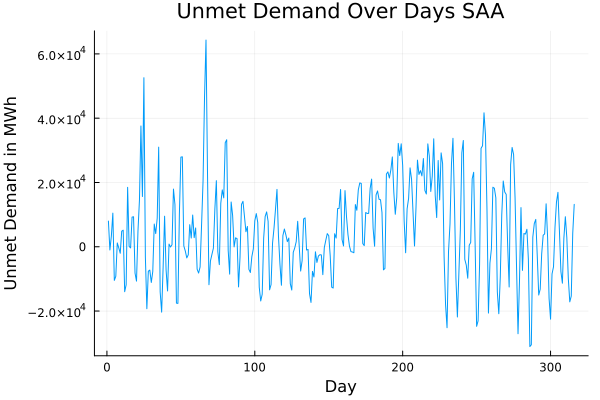

In [524]:
produced = [res.produced for res in SAA_evaluate_results]
not_met_true = [res.not_met_true for res in SAA_evaluate_results]
days = 1:T

# Plot for 'not_met_true'
plot(days, not_met_true, title = "Unmet Demand Over Days SAA", xlabel = "Day", ylabel = "Unmet Demand in MWh", legend = false)

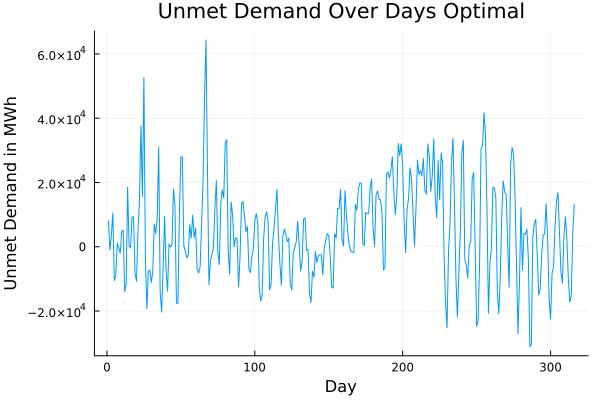

In [525]:
produced = [res.produced for res in Optimal_evaluate_results]
not_met_true = [res.not_met_true for res in Optimal_evaluate_results]
days = 1:T

# Plot for 'not_met_true'
plot(days, not_met_true, title = "Unmet Demand Over Days Optimal", xlabel = "Day", ylabel = "Unmet Demand in MWh", legend = false)

### Dummy model for baseline
Everyday, forecast demand (in this case using average y of the train set). Start producing from the cheapest source (Wind&Solar) until its capacity is saturated or the demand is met. If there's still demand left, move to the next cheapest source (petroleum), and so on.

In [526]:
forecast_demand = [mean(y_train) for t in 1:T];

# Sort production sources by cost (cheapest first)
#sorted_sources = sort(collect(production_cost), by = x -> x[2])

# Function to decide production
function decide_production(forecast_demand, production_capacity, sorted_sources=[3,2,1], T=316)
    production_plan = zeros(3, T)
    for t in 1:T
        remaining_demand = forecast_demand[t]

        for source in sorted_sources
            capacity = P[source]
            production = min(capacity, remaining_demand)
            production_plan[source,t] = production
            remaining_demand -= production
            if remaining_demand <= 0
                break
            end
        end
    end 
    return production_plan
end;

# Get the dummy production plan
dummy_prescriptions = decide_production(y_test, P);


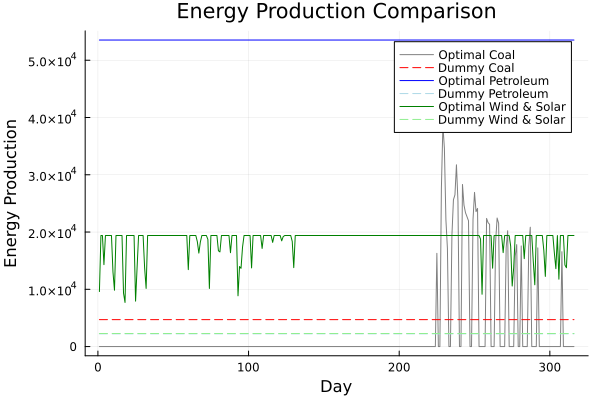

In [527]:
days = 1:T 

# Optimal prescriptions
optimal_coal = optimal_prescriptions[1, :];
optimal_petroleum = optimal_prescriptions[2, :];
optimal_wind_solar = optimal_prescriptions[3, :];

# SAA prescriptions
coal = prescriptions[1, :];
petroleum = prescriptions[2, :];
wind_solar = prescriptions[3, :];

# Baseline prescriptions
dummy_coal = dummy_prescriptions[1, :];
dummy_petroleum = dummy_prescriptions[2, :];
dummy_wind_solar = dummy_prescriptions[3, :];

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
#plot!(days, coal, label = "SAA Coal", color = :red, linestyle = :dash)
plot!(days, dummy_coal, label = "Dummy Coal", color = :red, linestyle = :dash)

plot!(days, optimal_petroleum, label = "Optimal Petroleum", color = :blue)
#plot!(days, petroleum, label = "SAA Petroleum", color = :lightblue, linestyle = :dash)
plot!(days, dummy_petroleum, label = "Dummy Petroleum", color = :lightblue, linestyle = :dash)

plot!(days, optimal_wind_solar, label = "Optimal Wind & Solar", color = :green)
#plot!(days, wind_solar, label = "SAA Wind & Solar", color = :lightgreen, linestyle = :dash)
plot!(days, dummy_wind_solar, label = "Dummy Wind & Solar", color = :lightgreen, linestyle = :dash)

title!("Energy Production Comparison")
xlabel!("Day")
ylabel!("Energy Production")


## KNN weighted approach

In [530]:
@sk_import neighbors: KNeighborsRegressor

PyObject <class 'sklearn.neighbors._regression.KNeighborsRegressor'>

In [531]:
# Train KNN classifier and use it to find the k nearest neighbors of each test sample
res = Dict()
k_max = 15

for n_neighbors=1:k_max
    
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_clf = fit!(knn, Matrix(JuMP.value.(X_train)), y_train)
    
    # Optimization problem 3
    model = Model(Gurobi.Optimizer)
    
    weights_knn = []
    
    for t=1:T
        # Get k nearest neighbors for each row j in test set
        neighbor_distances, neighbor_indices = knn_clf.kneighbors([Matrix(JuMP.value.(X_test))[t, :]], n_neighbors=n_neighbors) 
        
        neighbor_indices = neighbor_indices .+ 1 # bc this is a python package
        
        weighted_sum = sum(y_train[neighbor_indices])/n_neighbors
        
        push!(weights_knn, weighted_sum)
    end

    alpha = 1000

    model = Model(Gurobi.Optimizer);

    @variable(model, z[i=1:I,t=1:T] >= 0)

    @constraint(model, emissions_constraint, sum(sum(z[i,t] * e[i] for i=1:I) for t=1:T) <= E)
    @constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  C[i])

    # Auxiliary variable for modeling max operator in objective function
    @variable(model, u[t=1:T] >= 0) 
    for t in 1:T
        @constraint(model, u[t] >=  weights_knn[t] - sum(z[i,t] for i=1:I))
        @constraint(model, u[t] >= 0)
    end
    @objective(model, Min, sum(sum(z[i, t] * (c[i] - s) for i=1:I) + alpha * u[t] for t=1:T));
    
    # set_optimizer_attribute(model, "TimeLimit", 60.0);
    optimize!(model);
    
    optimal_prescriptions = JuMP.value.(z)
    obj_value = JuMP.objective_value(model)
    
    total_cost = sum(sum(optimal_prescriptions[i,t] * c[i] for i=1:I) for t=1:T)
    total_emissions = sum(sum(optimal_prescriptions[i,t] * e[i] for i=1:I) for t=1:T)
    total_sell = [min(y_test[t], sum(optimal_prescriptions[i,t] for i=1:I)) for t=1:T]
    total_revenue = p * sum(total_sell)
    total_profit = total_revenue - total_cost
    
    production = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
    unmet_demand = sum(y_test[t] - production[t] for t=1:T);

    res[n_neighbors] = [optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand]
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0xbad73e17
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.00s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9348330e+11   2.465158e+08   0.000000e+00      0s
     376   -6.1111365e+09   0.000000e+00   0.000000e+00 

In [532]:
res

Dict{Any, Any} with 15 entries:
  5  => Any[[0.0 0.0 … 0.0 0.0; 51725.5 52521.0 … 53520.0 53520.0; … ; 23832.0 …
  12 => Any[[0.0 0.0 … 0.0 0.0; 51707.2 52538.1 … 53520.0 53520.0; … ; 23832.0 …
  8  => Any[[0.0 0.0 … 0.0 0.0; 51733.8 52539.0 … 53520.0 53520.0; … ; 23832.0 …
  1  => Any[[0.0 0.0 … 0.0 0.0; 51770.3 52516.7 … 53520.0 53520.0; … ; 23832.0 …
  6  => Any[[0.0 0.0 … 0.0 0.0; 51712.6 52509.0 … 53520.0 53520.0; … ; 23832.0 …
  11 => Any[[0.0 0.0 … 0.0 0.0; 51716.8 52521.8 … 53520.0 53520.0; … ; 23832.0 …
  9  => Any[[0.0 0.0 … 0.0 0.0; 51745.1 52522.9 … 53520.0 53520.0; … ; 23832.0 …
  14 => Any[[0.0 0.0 … 0.0 0.0; 51684.6 52536.1 … 53520.0 53520.0; … ; 23832.0 …
  3  => Any[[0.0 0.0 … 0.0 0.0; 51713.9 52479.4 … 53520.0 53520.0; … ; 23832.0 …
  7  => Any[[0.0 0.0 … 0.0 0.0; 51719.2 52526.0 … 53520.0 53520.0; … ; 23832.0 …
  4  => Any[[0.0 0.0 … 0.0 0.0; 51735.7 52507.6 … 53520.0 53520.0; … ; 23832.0 …
  13 => Any[[0.0 0.0 … 0.0 0.0; 51696.6 52521.5 … 53520.0 53520.0; … ; 23832.

In [534]:
for i=1:k_max
    optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand = res[i][1],res[i][2],res[i][3],res[i][4],res[i][5]
   
    optimal_coal = optimal_prescriptions[1, :]
    optimal_gas = optimal_prescriptions[2, :]
    optimal_hydro = optimal_prescriptions[3, :]
    optimal_wind = optimal_prescriptions[4, :]
    optimal_solar = optimal_prescriptions[5, :]

    total_coal = sum(optimal_coal)
    total_gas = sum(optimal_gas)
    total_hydro = sum(optimal_hydro)
    total_wind = sum(optimal_wind)
    total_solar = sum(optimal_solar);

    push!(results, (Model="KNN = $i", Obj=obj_value, Profit=total_profit, Emissions=total_emissions, Unmet_Demand=unmet_demand, 
    Coal=total_coal, Gas=total_gas, Hydro=total_hydro, Wind=total_wind, Solar=total_solar))
end

In [567]:
results

21×10 DataFrame
 Row │ Model           Obj         Profit     Emissions   Unmet_Demand  Coal   ⋯
     │ String          Float64     Float64    Float64     Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PF - No Demand  -7.88478e9  7.88478e9  7.37535e10     2.03525e6  9.4194 ⋯
   2 │ PF - Demand     -7.42007e9  7.86766e9  7.37535e10     1.79036e6  1.1868
   3 │ SAA             -4.57892e6  7.61172e9  7.37535e10     1.65393e6  7.9149
   4 │ KNN = 1         -6.11114e9  7.85331e9  7.37535e10     1.80335e6  1.2061
   5 │ KNN = 2         -6.1015e9   7.85453e9  7.37535e10     1.79609e6  1.1953 ⋯
   6 │ KNN = 3         -6.10137e9  7.854e9    7.37535e10     1.79896e6  1.1996
   7 │ KNN = 4         -6.11209e9  7.85293e9  7.37535e10     1.79684e6  1.1964
   8 │ KNN = 5         -6.11722e9  7.85174e9  7.37535e10     1.79508e6  1.1938
   9 │ KNN = 6         -6.12451e9  7.85017e9  7.37535e10     1.7944e6   1.1928 ⋯
  10 │ KNN = 7         -6.12897e9  7.84941e9  7.37535e10     1.79507e6  1.1938
  11 │ KNN = 8         -6.12992e9  7.84984e9  7.37535e10     1.79779e6  1.1978
  12 │ KNN = 9         -6.13413e9  7.84918e9  7.37535e10     1.79682e6  1.1964
  13 │ KNN = 10        -6.13769e9  7.84998e9  7.37535e10     1.79753e6  1.1974 ⋯
  14 │ KNN = 11        -6.14256e9  7.85053e9  7.37535e10     1.7986e6   1.1990
  15 │ KNN = 12        -6.14913e9  7.8502e9   7.37535e10     1.8009e6   1.2024
  16 │ KNN = 13        -6.14986e9  7.84901e9  7.37535e10     1.79927e6  1.2000
  17 │ KNN = 14        -6.15448e9  7.8486e9   7.37535e10     1.79946e6  1.2003 ⋯
  18 │ KNN = 15        -6.15767e9  7.84762e9  7.37535e10     1.79868e6  1.1991
  19 │ PP - RF         -5.98093e9  7.78826e9  7.37535e10     1.73428e6  1.1035
  20 │ PP - ORT        -5.80933e9  7.75762e9  7.37535e10     1.68435e6  1.0294
  21 │ PP - SARIMA     -6.06843e9  7.73896e9  7.37535e10     1.72263e6  1.0862 ⋯
                                                               5 columns omitted

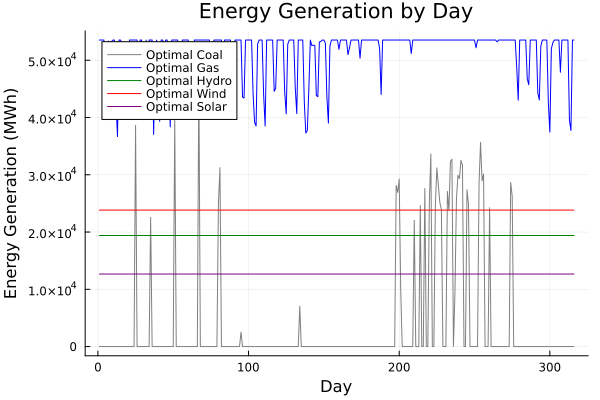

In [568]:
days = 1:T 

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
plot!(days, optimal_gas, label = "Optimal Gas", color = :blue)
plot!(days, optimal_hydro, label = "Optimal Hydro", color = :green)
plot!(days, optimal_wind, label = "Optimal Wind", color = :red)
plot!(days, optimal_solar, label = "Optimal Solar", color = :purple)

title!("Energy Generation by Day")
xlabel!("Day")
ylabel!("Energy Generation (MWh)")


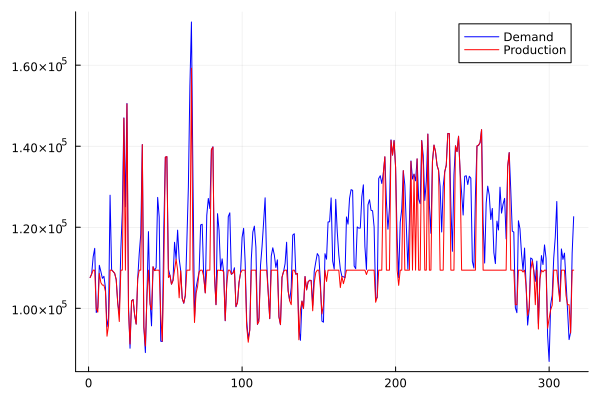

In [537]:
total_production_days = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
plot(days, y_test, label = "Demand", color = :blue)
plot!(days, total_production_days, label = "Production", color = :red)

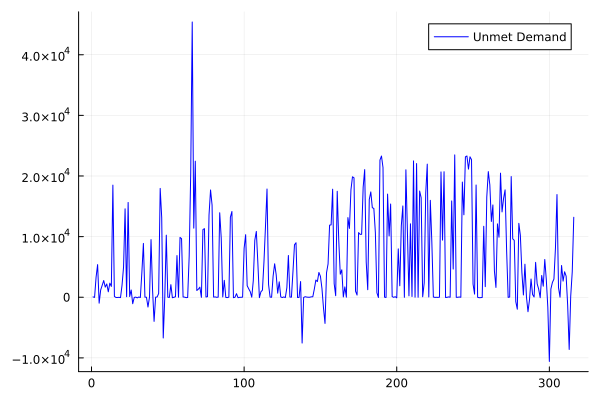

In [538]:
unmet_demand = y_test - total_production_days
plot(days, unmet_demand, label = "Unmet Demand", color = :blue)

## Point Prediction

In [540]:
first(df_preds, 5)

5×14 DataFrame
 Row │ Column1  pred_rf_naive  pred_rf_seasonal  pred_rf_cyclical  pred_rf_sea ⋯
     │ Int64    Float64        Float64           Float64           Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       0      1.21314e5         1.20433e5         1.19072e5              ⋯
   2 │       1      1.18465e5         1.17466e5         1.17056e5
   3 │       2      1.13428e5         1.13827e5         1.13537e5
   4 │       3      1.13596e5         1.13389e5         1.12924e5
   5 │       4  97876.6           98697.7           98785.8                    ⋯
                                                              10 columns omitted

In [541]:
function prescribe_pp(y_pred)
    model = Model(Gurobi.Optimizer);

    @variable(model, z[i=1:I,t=1:T] >= 0)

    @constraint(model, emissions_constraint, sum(sum(z[i,t] * e[i] for i=1:I) for t=1:T) <= E)
    @constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  C[i])

    # Auxiliary variable for modeling max operator in objective function
    @variable(model, u[t=1:T] >= 0) 
    @constraint(model, [t=1:T], u[t] >= y_pred[t] - sum(z[i,t] for i=1:I))
    @constraint(model, [t=1:T], u[t] >= 0)

    @objective(model, Min, sum(sum(z[i,t] * (c[i] - p) for i=1:I) + alpha * u[t] for t=1:T));

    optimize!(model);
    
    optimal_prescriptions = JuMP.value.(z)
    obj_value = JuMP.objective_value(model)
    
    total_cost = sum(sum(optimal_prescriptions[i,t] * c[i] for i=1:I) for t=1:T)
    total_emissions = sum(sum(optimal_prescriptions[i,t] * e[i] for i=1:I) for t=1:T)
    total_sell = [min(y_test[t], sum(optimal_prescriptions[i,t] for i=1:I)) for t=1:T]
    total_revenue = p * sum(total_sell)
    total_profit = total_revenue - total_cost

    production = [sum(optimal_prescriptions[i,t] for i=1:I) for t=1:T]
    unmet_demand = sum(y_test[t] - production[t] for t=1:T)

    return optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand
end

prescribe_pp (generic function with 1 method)

In [545]:
pred_rf = df_preds[!, :pred_rf_temporal]
pred_ort = df_preds[!, :pred_ORT_temporal]
pred_sarima = df_preds[!, :pred_sarima];

In [563]:
optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand = prescribe_pp(pred_rf)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0x832f103a
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.00s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9348330e+11   2.486615e+08   0.000000e+00      0s
     516   -5.9809253e+09   0.000000e+00   0.000000e+00      0s

Solved in 516 iterations and 0.01 seconds (0.01 work units)
Optimal objective -5.9

([0.0 0.0 … 0.0 0.0; 53520.0 53520.0 … 53520.0 53520.0; … ; 23832.0 23832.0 … 23832.0 23832.0; 12672.0 12672.0 … 12672.0 12672.0], -5.980925314334909e9, 7.375353424657535e10, 7.788263901734377e9, 1.7342840291382845e6)

In [564]:
avg_unmet = sum(unmet_demand) / T

5488.240598538875

In [565]:
optimal_coal = optimal_prescriptions[1, :]
optimal_gas = optimal_prescriptions[2, :]
optimal_hydro = optimal_prescriptions[3, :]
optimal_wind = optimal_prescriptions[4, :]
optimal_solar = optimal_prescriptions[5, :]

total_coal = sum(optimal_coal)
total_gas = sum(optimal_gas)
total_hydro = sum(optimal_hydro)
total_wind = sum(optimal_wind)
total_solar = sum(optimal_solar);

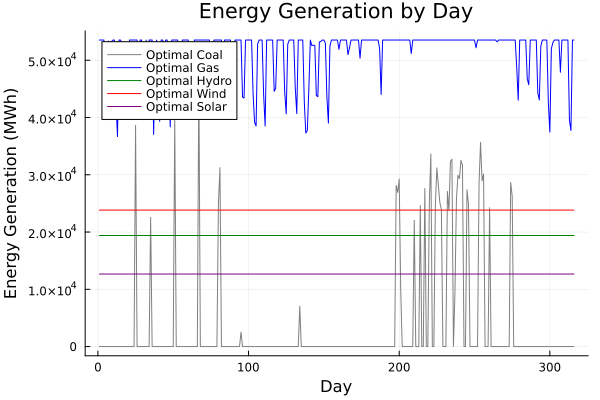

In [566]:
days = 1:T 

plot(days, optimal_coal, label = "Optimal Coal", color = :grey)
plot!(days, optimal_gas, label = "Optimal Gas", color = :blue)
plot!(days, optimal_hydro, label = "Optimal Hydro", color = :green)
plot!(days, optimal_wind, label = "Optimal Wind", color = :red)
plot!(days, optimal_solar, label = "Optimal Solar", color = :purple)

title!("Energy Generation by Day")
xlabel!("Day")
ylabel!("Energy Generation (MWh)")


In [550]:
push!(results, (Model="PP - RF", Obj=obj_value, Profit=total_profit, Emissions=total_emissions, Unmet_Demand=unmet_demand, 
    Coal=total_coal, Gas=total_gas, Hydro=total_hydro, Wind=total_wind, Solar=total_solar));

In [551]:
results

19×10 DataFrame
 Row │ Model           Obj         Profit     Emissions   Unmet_Demand  Coal   ⋯
     │ String          Float64     Float64    Float64     Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PF - No Demand  -7.88478e9  7.88478e9  7.37535e10     2.03525e6  9.4194 ⋯
   2 │ PF - Demand     -7.42007e9  7.86766e9  7.37535e10     1.79036e6  1.1868
   3 │ SAA             -4.57892e6  7.61172e9  7.37535e10     1.65393e6  7.9149
   4 │ KNN = 1         -6.11114e9  7.85331e9  7.37535e10     1.80335e6  1.2061
   5 │ KNN = 2         -6.1015e9   7.85453e9  7.37535e10     1.79609e6  1.1953 ⋯
   6 │ KNN = 3         -6.10137e9  7.854e9    7.37535e10     1.79896e6  1.1996
   7 │ KNN = 4         -6.11209e9  7.85293e9  7.37535e10     1.79684e6  1.1964
   8 │ KNN = 5         -6.11722e9  7.85174e9  7.37535e10     1.79508e6  1.1938
   9 │ KNN = 6         -6.12451e9  7.85017e9  7.37535e10     1.7944e6   1.1928 ⋯
  10 │ KNN = 7         -6.12897e9  7.84941e9  7.37535e10     1.79507e6  1.1938
  11 │ KNN = 8         -6.12992e9  7.84984e9  7.37535e10     1.79779e6  1.1978
  12 │ KNN = 9         -6.13413e9  7.84918e9  7.37535e10     1.79682e6  1.1964
  13 │ KNN = 10        -6.13769e9  7.84998e9  7.37535e10     1.79753e6  1.1974 ⋯
  14 │ KNN = 11        -6.14256e9  7.85053e9  7.37535e10     1.7986e6   1.1990
  15 │ KNN = 12        -6.14913e9  7.8502e9   7.37535e10     1.8009e6   1.2024
  16 │ KNN = 13        -6.14986e9  7.84901e9  7.37535e10     1.79927e6  1.2000
  17 │ KNN = 14        -6.15448e9  7.8486e9   7.37535e10     1.79946e6  1.2003 ⋯
  18 │ KNN = 15        -6.15767e9  7.84762e9  7.37535e10     1.79868e6  1.1991
  19 │ PP - RF         -5.98093e9  7.78826e9  7.37535e10     1.73428e6  1.1035
                                                               5 columns omitted

In [552]:
optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand = prescribe_pp(pred_ort)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0xf4f25f14
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.00s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9348330e+11   5.614256e+06   0.000000e+00      0s
      28   -5.8093310e+09   0.000000e+00   0.000000e+00      0s

Use crossover to convert LP symmetric solution to basic solution...
Crossover log.

([0.0 0.0 … 0.0 0.0; 53520.0 53520.0 … 53520.0 53520.0; … ; 23832.0 23832.0 … 23832.0 23832.0; 12672.0 12672.0 … 12672.0 12672.0], -5.809331002374611e9, 7.375353424657535e10, 7.757622671959894e9, 1.6843452638429462e6)

In [553]:
avg_unmet = sum(unmet_demand) / T

5330.206531148564

In [554]:
optimal_coal = optimal_prescriptions[1, :]
optimal_gas = optimal_prescriptions[2, :]
optimal_hydro = optimal_prescriptions[3, :]
optimal_wind = optimal_prescriptions[4, :]
optimal_solar = optimal_prescriptions[5, :]

total_coal = sum(optimal_coal)
total_gas = sum(optimal_gas)
total_hydro = sum(optimal_hydro)
total_wind = sum(optimal_wind)
total_solar = sum(optimal_solar);

In [555]:
push!(results, (Model="PP - ORT", Obj=obj_value, Profit=total_profit, Emissions=total_emissions, Unmet_Demand=unmet_demand, 
    Coal=total_coal, Gas=total_gas, Hydro=total_hydro, Wind=total_wind, Solar=total_solar));

In [556]:
results

20×10 DataFrame
 Row │ Model           Obj         Profit     Emissions   Unmet_Demand  Coal   ⋯
     │ String          Float64     Float64    Float64     Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PF - No Demand  -7.88478e9  7.88478e9  7.37535e10     2.03525e6  9.4194 ⋯
   2 │ PF - Demand     -7.42007e9  7.86766e9  7.37535e10     1.79036e6  1.1868
   3 │ SAA             -4.57892e6  7.61172e9  7.37535e10     1.65393e6  7.9149
   4 │ KNN = 1         -6.11114e9  7.85331e9  7.37535e10     1.80335e6  1.2061
   5 │ KNN = 2         -6.1015e9   7.85453e9  7.37535e10     1.79609e6  1.1953 ⋯
   6 │ KNN = 3         -6.10137e9  7.854e9    7.37535e10     1.79896e6  1.1996
   7 │ KNN = 4         -6.11209e9  7.85293e9  7.37535e10     1.79684e6  1.1964
   8 │ KNN = 5         -6.11722e9  7.85174e9  7.37535e10     1.79508e6  1.1938
   9 │ KNN = 6         -6.12451e9  7.85017e9  7.37535e10     1.7944e6   1.1928 ⋯
  10 │ KNN = 7         -6.12897e9  7.84941e9  7.37535e10     1.79507e6  1.1938
  11 │ KNN = 8         -6.12992e9  7.84984e9  7.37535e10     1.79779e6  1.1978
  12 │ KNN = 9         -6.13413e9  7.84918e9  7.37535e10     1.79682e6  1.1964
  13 │ KNN = 10        -6.13769e9  7.84998e9  7.37535e10     1.79753e6  1.1974 ⋯
  14 │ KNN = 11        -6.14256e9  7.85053e9  7.37535e10     1.7986e6   1.1990
  15 │ KNN = 12        -6.14913e9  7.8502e9   7.37535e10     1.8009e6   1.2024
  16 │ KNN = 13        -6.14986e9  7.84901e9  7.37535e10     1.79927e6  1.2000
  17 │ KNN = 14        -6.15448e9  7.8486e9   7.37535e10     1.79946e6  1.2003 ⋯
  18 │ KNN = 15        -6.15767e9  7.84762e9  7.37535e10     1.79868e6  1.1991
  19 │ PP - RF         -5.98093e9  7.78826e9  7.37535e10     1.73428e6  1.1035
  20 │ PP - ORT        -5.80933e9  7.75762e9  7.37535e10     1.68435e6  1.0294
                                                               5 columns omitted

In [557]:
optimal_prescriptions, obj_value, total_emissions, total_profit, unmet_demand = prescribe_pp(pred_sarima)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2213 rows, 1896 columns and 5372 nonzeros
Model fingerprint: 0xc538bb1c
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 7e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1896 rows and 0 columns
Presolve time: 0.00s
Presolved: 317 rows, 1896 columns, 3476 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9348330e+11   2.486422e+08   0.000000e+00      0s
     518   -6.0684344e+09   0.000000e+00   0.000000e+00      0s

Solved in 518 iterations and 0.01 seconds (0.01 work units)
Optimal objective -6.0

([0.0 0.0 … 0.0 0.0; 53520.0 53520.0 … 53520.0 53520.0; … ; 23832.0 23832.0 … 23832.0 23832.0; 12672.0 12672.0 … 12672.0 12672.0], -6.068434386280461e9, 7.375353424657536e10, 7.738958646821293e9, 1.7226335961470134e6)

In [558]:
avg_unmet = sum(unmet_demand) / T

5451.372139705739

In [559]:
optimal_coal = optimal_prescriptions[1, :]
optimal_gas = optimal_prescriptions[2, :]
optimal_hydro = optimal_prescriptions[3, :]
optimal_wind = optimal_prescriptions[4, :]
optimal_solar = optimal_prescriptions[5, :]

total_coal = sum(optimal_coal)
total_gas = sum(optimal_gas)
total_hydro = sum(optimal_hydro)
total_wind = sum(optimal_wind)
total_solar = sum(optimal_solar);

In [560]:
push!(results, (Model="PP - SARIMA", Obj=obj_value, Profit=total_profit, Emissions=total_emissions, Unmet_Demand=unmet_demand, 
    Coal=total_coal, Gas=total_gas, Hydro=total_hydro, Wind=total_wind, Solar=total_solar));

In [561]:
results

21×10 DataFrame
 Row │ Model           Obj         Profit     Emissions   Unmet_Demand  Coal   ⋯
     │ String          Float64     Float64    Float64     Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PF - No Demand  -7.88478e9  7.88478e9  7.37535e10     2.03525e6  9.4194 ⋯
   2 │ PF - Demand     -7.42007e9  7.86766e9  7.37535e10     1.79036e6  1.1868
   3 │ SAA             -4.57892e6  7.61172e9  7.37535e10     1.65393e6  7.9149
   4 │ KNN = 1         -6.11114e9  7.85331e9  7.37535e10     1.80335e6  1.2061
   5 │ KNN = 2         -6.1015e9   7.85453e9  7.37535e10     1.79609e6  1.1953 ⋯
   6 │ KNN = 3         -6.10137e9  7.854e9    7.37535e10     1.79896e6  1.1996
   7 │ KNN = 4         -6.11209e9  7.85293e9  7.37535e10     1.79684e6  1.1964
   8 │ KNN = 5         -6.11722e9  7.85174e9  7.37535e10     1.79508e6  1.1938
   9 │ KNN = 6         -6.12451e9  7.85017e9  7.37535e10     1.7944e6   1.1928 ⋯
  10 │ KNN = 7         -6.12897e9  7.84941e9  7.37535e10     1.79507e6  1.1938
  11 │ KNN = 8         -6.12992e9  7.84984e9  7.37535e10     1.79779e6  1.1978
  12 │ KNN = 9         -6.13413e9  7.84918e9  7.37535e10     1.79682e6  1.1964
  13 │ KNN = 10        -6.13769e9  7.84998e9  7.37535e10     1.79753e6  1.1974 ⋯
  14 │ KNN = 11        -6.14256e9  7.85053e9  7.37535e10     1.7986e6   1.1990
  15 │ KNN = 12        -6.14913e9  7.8502e9   7.37535e10     1.8009e6   1.2024
  16 │ KNN = 13        -6.14986e9  7.84901e9  7.37535e10     1.79927e6  1.2000
  17 │ KNN = 14        -6.15448e9  7.8486e9   7.37535e10     1.79946e6  1.2003 ⋯
  18 │ KNN = 15        -6.15767e9  7.84762e9  7.37535e10     1.79868e6  1.1991
  19 │ PP - RF         -5.98093e9  7.78826e9  7.37535e10     1.73428e6  1.1035
  20 │ PP - ORT        -5.80933e9  7.75762e9  7.37535e10     1.68435e6  1.0294
  21 │ PP - SARIMA     -6.06843e9  7.73896e9  7.37535e10     1.72263e6  1.0862 ⋯
                                                               5 columns omitted

In [ ]:
# Coefficient of prescriptiveness
saa = 